In [4]:
import numpy as np
import importlib
import util as uti
import matplotlib.pyplot as plt
importlib.reload(uti)

# import math lib
from math import pi

# import Qiskit
from qiskit import Aer, IBMQ, execute, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import GroverOperator

# import basic plot tools
#import qiskit.visualization as vis
from qiskit.visualization import plot_histogram
%matplotlib inline

/home/kinga/.local/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


# overlap calculation

# state preparation

In [1]:
def calc_amplitudes(v):
    ''' amplitude encoding of raw input vector v '''
    ''' TODO: compare with qiskit's RawFeatureVector '''
    norm = np.linalg.norm(v)
    return v/norm

In [11]:
def prepare_swap_state_amplitudes(a_q, b_q):
    # first state psi 1/sqrt(2) (|0,a> + \1,b>)
    psi = np.hstack([a_q, b_q]) * (1/np.sqrt(2))
    a_q_norm = np.linalg.norm(a_q)
    b_q_norm = np.linalg.norm(b_q)
    Z = a_q_norm**2 + b_q_norm**2
    # second state phi with identity
    phi = np.array([a_q_norm, -b_q_norm]) * (1/np.sqrt(Z))
    return psi, phi, Z

# swap test

In [ ]:
def swap_test(psi, phi):
    
    backend = Aer.get_backend('qasm_simulator')
    # create circuit with n qubits and one classical bit for measurement
    # qubits: first: ancilla, second: input vector, third: cluster center
    #(for latent space in R^2: 1 (ancilla) + 1 (x1,x2 coords of input) + 1 (x1,x2 coords of cluster))
    n = int((len(psi)+len(phi))/2)+1
    
    qc = QuantumCircuit(n, 1, name="swap_test")
    
    # load data
    # ancilla qubit default 0
    # first and second qubits init to psi
    qc.initialize(v1_amp, [2:3])

# input data

In [53]:
a = np.array([10., 1])
b = np.array([-2., 40])
# amplitude enoded
a_q = calc_amplitudes(a)
b_q = calc_amplitudes(b)

In [54]:
print(a, b)
print(a_q, b_q)

[10.  1.] [-2. 40.]
[0.99503719 0.09950372] [-0.04993762  0.99875234]


In [55]:
psi, phi, Z = prepare_swap_state_amplitudes(a_q, b_q)

In [56]:
print(psi)
print(phi)
print(Z)

[ 0.70359754  0.07035975 -0.03531123  0.70622455]
[ 0.70710678 -0.70710678]
1.9999999999999996


In [57]:
backend = Aer.get_backend('qasm_simulator')
# create circuit with n qubits and one classical bit for measurement
# qubits: first: ancilla, second: input vector, third: cluster center
#(for latent space in R^2: 1 (ancilla) + 1 (x1,x2 coords of input) + 1 (x1,x2 coords of cluster))
n = int((len(psi)+len(phi))/2)+1
print('n ', n)
qc = QuantumCircuit(n, 1, name="swap_test")

# load data
# control qubit default 0
# first and second qubits init to psi (tensorproduct of ancilla qubit and vector value)
qc.initialize(psi, [1,2])
# third qubit init to phi
qc.initialize(phi, 3)
qc.barrier()
# apply hadamard to control
qc.h(0)
# swap psi ancilla with phi
qc.cswap(0,1,3)
# apply second hadamard
qc.h(0)
# measure control qubit
qc.measure(0,0)
qc.draw()

n  4


░ ┌───┐   ┌───┐┌─┐
q_0: ──────────────────────────────────────────────────░─┤ H ├─■─┤ H ├┤M├
     ┌───────────────────────────────────────────────┐ ░ └───┘ │ └───┘└╥┘
q_1: ┤0                                              ├─░───────X───────╫─
     │  initialize(0.7036,0.07036,-0.035311,0.70622) │ ░       │       ║ 
q_2: ┤1                                              ├─░───────┼───────╫─
     └────────┬──────────────────────────────┬───────┘ ░       │       ║ 
q_3: ─────────┤ initialize(0.70711,-0.70711) ├─────────░───────X───────╫─
              └──────────────────────────────┘         ░               ║ 
c: 1/══════════════════════════════════════════════════════════════════╩═
                                                                       0

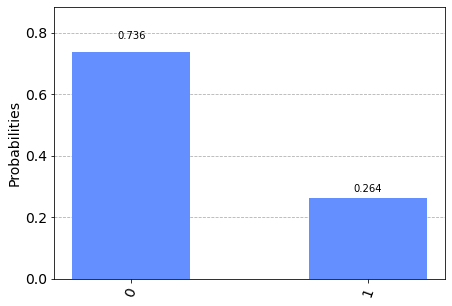

In [58]:
shots = 1024
qobj = assemble(qc, backend)
results = backend.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [112]:
# basic swap test directly on quantum states that are rotated against each other
def swap_test_basic(rotate_a, rotate_b):
    
    backend = Aer.get_backend('qasm_simulator')
    # create circuit with n qubits and one classical bit for measurement
    # qubits: first: ancilla, second: input vector, third: cluster center
    #(for latent space in R^2: 1 (ancilla) + 1 (x1,x2 coords of input) + 1 (x1,x2 coords of cluster))
    n = 2+1
    qc = QuantumCircuit(n, 1, name="swap_test")

    # load data
    # control qubit default 0
    # rotate qubit a
    qc.u(rotate_a, 0, 0, 1)
    # rotate qubit b
    qc.u(rotate_b, 0, 0, 2)
    # third qubit init to phi
    qc.barrier()
    # apply hadamard to control
    qc.h(0)
    # swap psi ancilla with phi
    qc.cswap(0,1,2)
    # apply second hadamard
    qc.h(0)
    # measure control qubit
    qc.measure(0,0)
    qc.draw()
    
    shots = 1024
    qobj = assemble(qc, backend)
    results = backend.run(qobj).result()
    answer = results.get_counts()

    return qc, answer

In [152]:
qc, answer = swap_test_basic(np.pi,0)

In [153]:
qc.draw()

░ ┌───┐   ┌───┐┌─┐
q_0: ─────────────░─┤ H ├─■─┤ H ├┤M├
     ┌──────────┐ ░ └───┘ │ └───┘└╥┘
q_1: ┤ U(π,0,0) ├─░───────X───────╫─
     ├──────────┤ ░       │       ║ 
q_2: ┤ U(0,0,0) ├─░───────X───────╫─
     └──────────┘ ░               ║ 
c: 1/═════════════════════════════╩═
                                  0

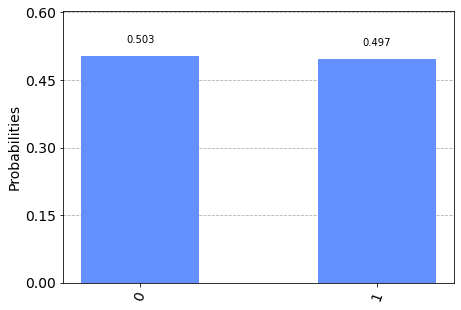

In [154]:
plot_histogram(answer)

In [155]:
answer

{'0': 515, '1': 509}

In [156]:
def calculate_overlap(answer):
    shots = answer['0'] if len(answer) == 1 else answer['0']+answer['1']
    return np.abs(answer['0']/shots - 0.5) * 2

In [157]:
calculate_overlap(answer)

0.005859375

In [180]:
# caluclate overlaps for different qubit rotations
angle_diffs = []
overlaps = []
for rot_a in np.linspace(0,pi,20):
    for rot_b in np.linspace(0,pi,20):
        _, answer = swap_test_basic(rot_a,rot_b)
        overlap = calculate_overlap(answer)
        angle_diffs.append(np.abs(rot_a - rot_b))
        overlaps.append(overlap)

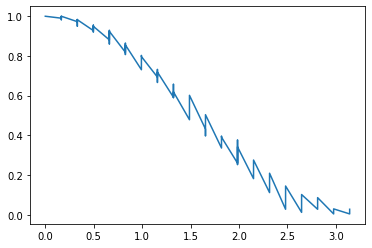

In [181]:
# plot results
angle_diffs_sorted, overlaps_sorted = zip(*sorted(zip(angle_diffs, overlaps)))
plt.plot(angle_diffs_sorted, overlaps_sorted)

In [102]:
from qiskit.visualization import plot_bloch_multivector, plot_histogram
sim = Aer.get_backend('aer_simulator')
# Let's have U-gate transform a |0> to |+> state
qc = QuantumCircuit(1)
qc.u(0.5, 0, 0, 0)
qc.draw()

┌────────────┐
q_0: ┤ U(0.5,0,0) ├
     └────────────┘

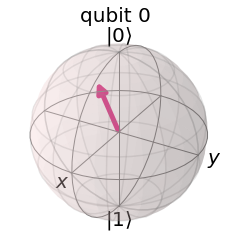

In [103]:
# Let's see the result
qc.save_statevector()
qobj = assemble(qc)
state = sim.run(qobj).result().get_statevector()
plot_bloch_multivector(state)

In [2]:
# create circuit
n = 2
circ = QuantumCircuit(n+1)
circ.h(0)

In [3]:
# overlap 0 & 1
circ.x(1)

In [4]:
circ.cswap(0,1,2)

In [5]:
circ.h(0)

In [6]:
circ.measure

<bound method measure of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fbbb820a2b0>>